In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
import sklearn
import warnings
from tqdm.notebook import tqdm
from pathlib import Path
warnings.filterwarnings('ignore')


import tensorflow as tf
# from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
EDA

In [ ]:
train_dir = 'train'
image = []
age = []
for folder in os.listdir(train_dir):
  for file_name in os.listdir(train_dir+'/'+str(folder)):
    file_name_path = train_dir+'/'+str(folder)+'/'+file_name
    image_age = int(file_name.split('_')[0])
    image.append(file_name_path)
    age.append(image_age)

train_label = pd.DataFrame({'image': image, 'age': age})
train_label


,image,age
0,train/1/1_0_0_20161219140623097.jpg.chip.jpg,1
1,train/1/1_0_0_20161219140627985.jpg.chip.jpg,1
2,train/1/1_0_0_20161219140642920.jpg.chip.jpg,1
3,train/1/1_0_0_20161219154018476.jpg.chip.jpg,1
4,train/1/1_0_0_20161219154556757.jpg.chip.jpg,1
...,...,...
23686,train/99/99_1_0_20170120134718759.jpg.chip.jpg,99
23687,train/99/99_1_0_20170120221920654.jpg.chip.jpg,99
23688,train/99/99_1_1_20170120134639935.jpg.chip.jpg,99
23689,train/99/99_1_2_20170110182418864.jpg.chip.jpg,99


In [ ]:
train_label.info()
train_label.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23691 entries, 0 to 23690
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   23691 non-null  object
 1   age     23691 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 370.3+ KB


,age
count,23691.000000
mean,33.310455
std,19.888984
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


<AxesSubplot: xlabel='age', ylabel='Density'>

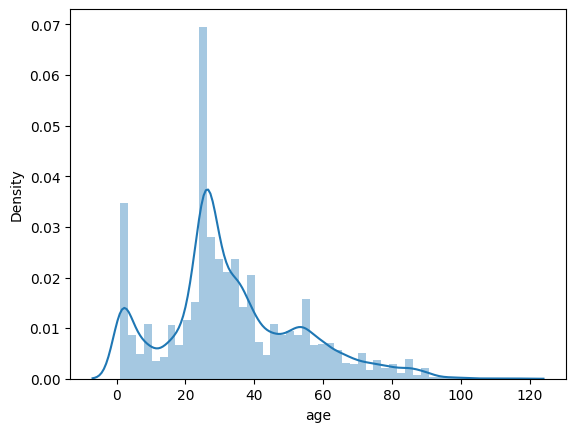

In [ ]:
# Phân phối độ tuổi
sns.distplot(train_label['age'])

<AxesSubplot: >

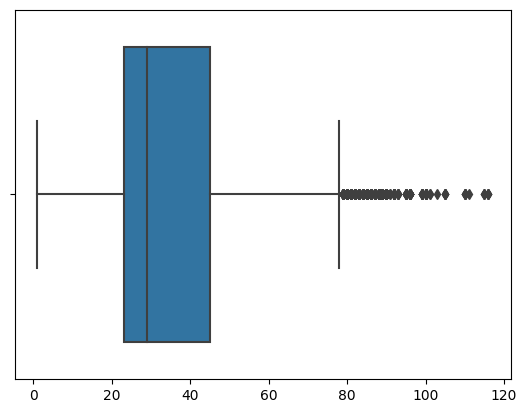

In [ ]:
sns.boxplot(x=train_label['age'].values)

PROCESSING DATA



In [ ]:
# extract features function
def extract_features(images):
    features = []
    for image in images:
        img = tf.keras.preprocessing.image.load_img(image, grayscale=True)
        img = img.resize((128, 128))
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
# processing train images for CNN model
X_train = extract_features(train_label['image'])
X_train = X_train/255.0
y_train = np.array(train_label['age'])

In [ ]:
test_dir = 'test'
image = []
age = []
for folder in os.listdir(test_dir):
  for file_name in os.listdir(test_dir+'/'+str(folder)):
    file_name_path = test_dir+'/'+str(folder)+'/'+file_name
    image_age = int(folder)
    image.append(file_name_path)
    age.append(image_age)

test_label = pd.DataFrame({'image': image, 'age': age})
test_label

,image,age
0,test/20/28492.jpg,20
1,test/20/28521.jpg,20
2,test/20/28681.jpg,20
3,test/20/28801.jpg,20
4,test/20/28815.jpg,20
...,...,...
7001,test/50/44644.jpg,50
7002,test/50/44666.jpg,50
7003,test/50/44679.jpg,50
7004,test/50/44719.jpg,50


In [3]:
#  detect face from test image
haar_file = 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haar_file)
(width, height) = (128, 128)
def detect_face(path):
    out_put = []
    for i in path:
        im = plt.imread(i)
        faces = face_cascade.detectMultiScale(im, 1.3, 4)
        for (x, y, w, h) in faces:
            cv2.rectangle(im, (x, y), (x + w, y + h), (255, 0, 0), 2)
            face = im[y:y + h, x:x + w]
            face_resize = cv2.resize(face, (width, height))
        out_put.append(face_resize)
    out_put = np.array(out_put)
    return out_put

In [ ]:
# detect face from test image
detected_face = detect_face(test_label['image'].values)

In [5]:
# extract_feature test image function
def extract_features_test(images):
    features = []
    for i in images:
        gray = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        features.append(gray)
    features = np.array(features)
    features = features/255
    return features

In [ ]:
# processing test images
X_test = extract_features_test(detected_face)
y_test = np.array(test_label['age'])

(-0.5, 127.5, 127.5, -0.5)

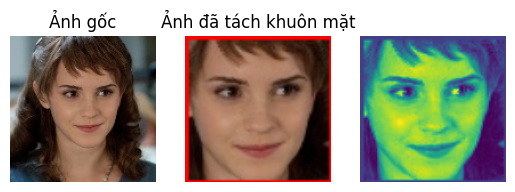

In [ ]:
  ax1 = plt.subplot(131)
  ax2 = plt.subplot(132)
  ax3 = plt.subplot(133)
  index = 302
  anh_goc = plt.imread(test_label['image'].values[index])
  khuon_mat = detected_face[index]
  dac_trung = X_test[index]
  ax1.imshow(anh_goc)
  ax2.imshow(khuon_mat)
  ax3.imshow(dac_trung)
  ax1.set_title('Ảnh gốc')
  ax2.set_title('Ảnh đã tách khuôn mặt')
  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')

BUILD CNN MODEL

In [ ]:
input_shape = (128, 128, 1)
inputs = Input((input_shape))

# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_2 = Dense(256, activation='relu') (flatten)

dropout_2 = Dropout(0.3) (dense_2)

output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_2])

model.compile(loss='mse', optimizer='adam')

In [ ]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856 

TRAIN AND SAVE MODEL

In [ ]:
model = tf.keras.models.load_model('saved_models/model_5.h5')

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks =[earlystopping])

model.save('saved_models/model_5.h5')

Epoch 1/10
593/593 [==============================] - 515s 864ms/step - loss: 38.5352 - val_loss: 482.0941
Epoch 2/10
593/593 [==============================] - 524s 883ms/step - loss: 36.0354 - val_loss: 324.1600
Epoch 3/10
593/593 [==============================] - 500s 842ms/step - loss: 32.2788 - val_loss: 439.7152
Epoch 4/10
593/593 [==============================] - 496s 837ms/step - loss: 28.3074 - val_loss: 399.3125
Epoch 5/10
593/593 [==============================] - 497s 838ms/step - loss: 25.4531 - val_loss: 439.7450
Epoch 6/10
593/593 [==============================] - 490s 827ms/step - loss: 23.2747 - val_loss: 383.8615
Epoch 7/10
593/593 [==============================] - 502s 847ms/step - loss: 21.4329 - val_loss: 425.5510


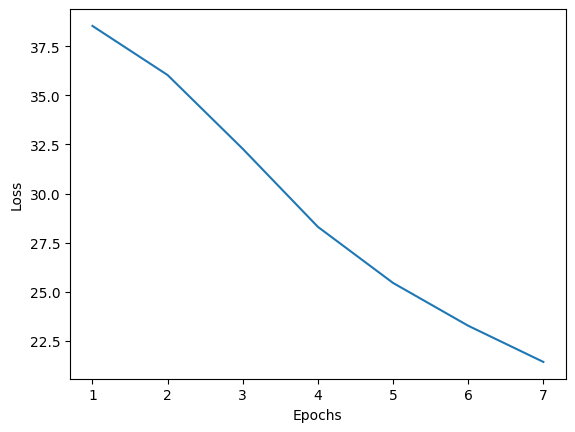

In [ ]:
loss = history.history['loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

LOAD MODEL

In [7]:
cnn_model = tf.keras.models.load_model('saved_models/model_4.h5')

TEST MODEL

Original Age:  41
1/1 [==============================] - 0s 38ms/step
Predicted Age: 37


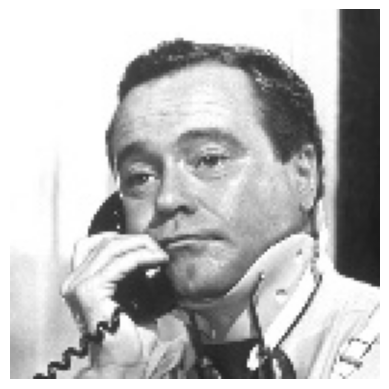

In [ ]:
# test with specific image in test images set
import matplotlib
image_index = 5000
print("Original Age: ", y_test[image_index])
# predict from model
pred = cnn_model.predict(X_test[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
img = matplotlib.image.imread(test_label['image'].values[image_index])
plt.axis('off')
plt.imshow(img);

Original Age:  28
1/1 [==============================] - 0s 57ms/step
Predicted Age: 31


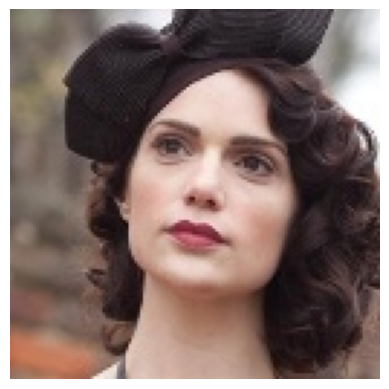

In [ ]:
# test with specific image in test images set
import matplotlib
image_index = 2000
print("Original Age: ", y_test[image_index])
# predict from model
pred = cnn_model.predict(X_test[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
img = matplotlib.image.imread(test_label['image'].values[image_index])
plt.axis('off')
plt.imshow(img);

Original Age:  45
1/1 [==============================] - 1s 1s/step
Predicted Age: 43


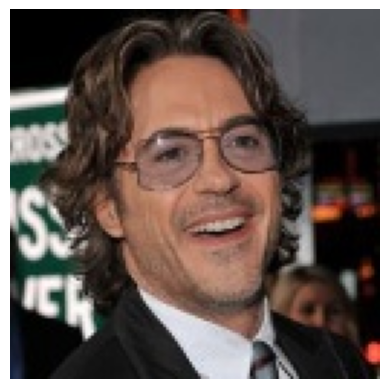

In [ ]:
# test with specific image in test images set
import matplotlib
image_index = 6000
print("Original Age: ", y_test[image_index])
# predict from model
pred = cnn_model.predict(X_test[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
img = matplotlib.image.imread(test_label['image'].values[image_index])
plt.axis('off')
plt.imshow(img);

In [ ]:
# test with all test images
pred = cnn_model.predict(X_test)
pred_age = []
true_age = []
for i in range(0, len(pred)):
    pred_age.append(round(pred[i][0]))
    true_age.append(y_test[i])
test_result = pd.DataFrame({'image': file_name, 'pred_age': pred_age, 'true_age': true_age})
test_result

219/219 [==============================] - 51s 228ms/step


,image,pred_age,true_age
0,44723.jpg,29,20
1,44723.jpg,9,20
2,44723.jpg,29,20
3,44723.jpg,17,20
4,44723.jpg,29,20
...,...,...,...
7001,44723.jpg,36,50
7002,44723.jpg,36,50
7003,44723.jpg,36,50
7004,44723.jpg,36,50


1/1 [==============================] - 1s 544ms/step
Predicted Age: 20


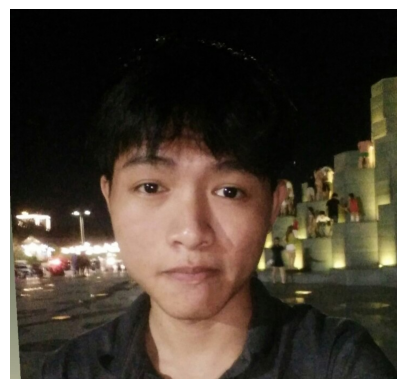

In [8]:
# test for user image
import matplotlib.pyplot as plt
path = 'z3850238868064_1a4dfabf35a46684ef9616eb57b8ab35.jpg'
my_img = plt.imread(path)
my_face = detect_face(np.array(path).reshape(1,))
my_face_features = extract_features_test(my_face)
pred = cnn_model.predict(my_face_features.reshape(1, 128, 128, 1))
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(my_img);

EVALUATE MODEL

In [ ]:
test_loss = cnn_model.evaluate(X_test, y_test)[0]
print('MSE =', test_loss)

219/219 [==============================] - 43s 188ms/step - loss: 256.7994 - accuracy: 0.0000e+00
MSE = 256.7994384765625


In [ ]:
mae = abs(test_result['pred_age']-test_result['true_age'])
MAE = sum(mae)/len(mae)
print('MAE =', MAE)

MAE = 13.111618612617756
